### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop

### Extracting the data from the dataset
Download the dataset from [Here](https://www.kaggle.com/datasets/jangedoo/utkface-new)

In [2]:
fldr= "./UTKFace"
files = os.listdir(fldr)

### Populating list of age, gender and image from the dataset

In [3]:
ages= []
genders = []
images = []

for fle in files:
    age = int(fle.split('_')[0])
    gender = int(fle.split('_')[1])
    ages.append(age)
    genders.append(gender)
    
    total = fldr+'/'+fle
    image = cv2.imread(total)
    image = cv2.resize(image, (48,48))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

### Saving ages, genders and images arrays in the system

In [4]:
ages_f = np.array(ages)
genders_f = np.array(genders)
images_f = np.array(images)

In [5]:
np.save(fldr+'image.npy',images_f)
np.save(fldr+'age.npy',ages_f)
np.save(fldr+'gender.npy',genders_f)

### Plotting the number of Male and Female samples

In [6]:
values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[12391 11317]


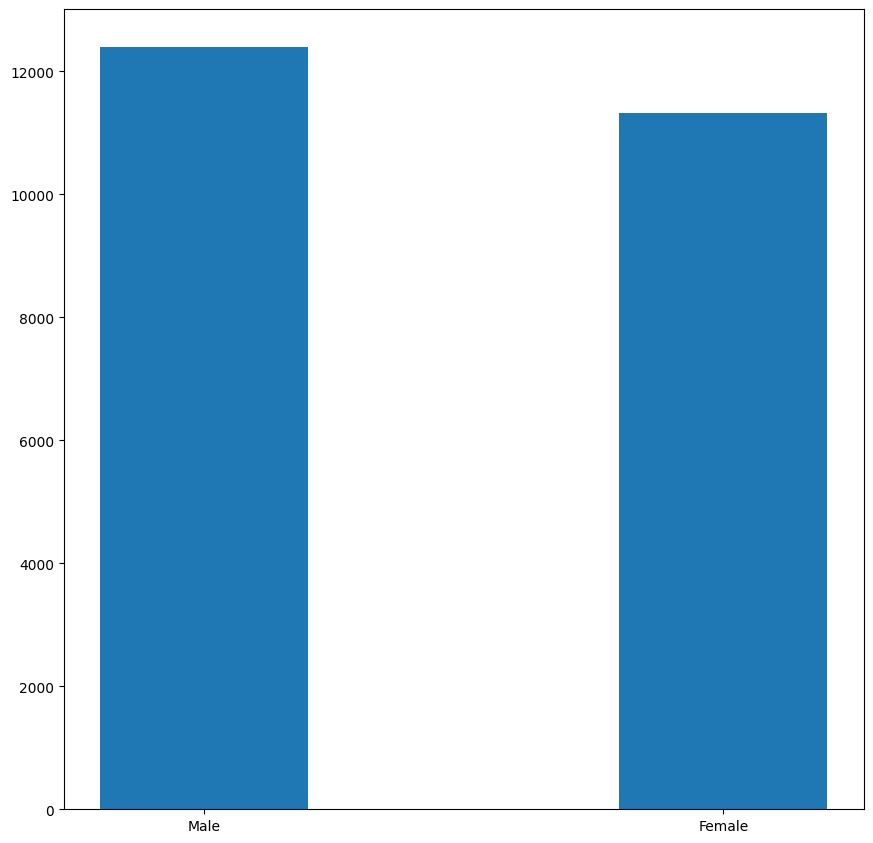

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
values = [12391, 11317]
ax.bar(gender,values, width=0.4)
plt.show()

### Plotting the samples Agewise

In [8]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


In [9]:
val = values.tolist()
cnt = counts.tolist()

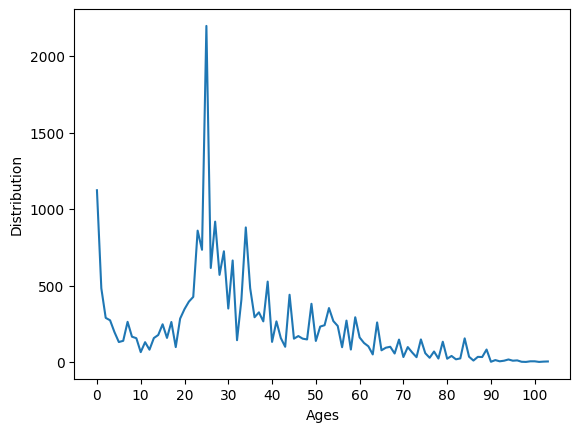

In [10]:
plt.plot(counts)
plt.xticks(np.arange(0, 110, 10))
plt.xlabel('Ages')
plt.ylabel('Distribution')
plt.show()


### Defining labels for the output

In [11]:
labels = []
i=0

while(i<len(ages)):
    label = []
    label.append(ages[i])
    label.append(genders[i])
    labels.append(label)
    i += 1

### Creating simplified image list for better learning of our model

In [12]:
images_f_2 = images_f/255

In [13]:
images_f_2.shape

(23708, 48, 48, 3)

In [14]:
labels_f = np.array(labels)

In [46]:
labels_f.shape

(23708, 2)

### Splitting dataset into train and test data

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_f_2, labels_f, test_size=0.25, random_state=42)

### Splitting the 'y_train' and 'y_test' data further for better analysis

In [17]:
y_train_2 = [y_train[:,1],y_train[:, 0]]
y_test_2 = [y_test[:,1],y_test[:, 0]]

### Defining the Deep Learning Convolutional Model or CNN

In [25]:
def Convolution(input_tensor, filters):
    x=Conv2D(filters=filters, kernel_size=(3,3), padding="same", strides=(1,1), kernel_regularizer=l2(0.001))(input_tensor)
    x=Dropout(0.1)(x)
    x=Activation('relu')(x)
    return x

In [26]:
def model(input_shape):
    inputs = Input((input_shape))
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = Convolution(maxp_1, 64)
    maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = Convolution(maxp_2, 128)
    maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
    conv_4 = Convolution(maxp_3, 256)
    maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)
    
    flatten = Flatten()(maxp_4)
    dense_1 = Dense(64, activation='relu')(flatten)
    dense_2 = Dense(64, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)
    output_1 = Dense(1, activation='sigmoid', name='sex_out')(drop_1)
    output_2 = Dense(1, activation='relu', name='age_out')(drop_2)
    
    model = Model(inputs=[inputs], outputs = [output_1, output_2])
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer='Adam', metrics=['accuracy'])
    
    return model

In [47]:
Model = model((48, 48, 3))

In [48]:
Model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 48, 48, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 48, 48, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 48, 48, 32)   0           dropout_12[0][0]                 
____________________________________________________________________________________________

### Initializing the Model

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [50]:
file_s = "Age_Sex_Detector.h5"
checkpoint = ModelCheckpoint(file_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience = 75, monitor = 'val_loss', restore_best_weights = 'True')
callback_list = [checkpoint, Early_stop]

### Model Training

**Note:** You can increase the number of epochs for better accuracy but it is time taking.

In [51]:
History = Model.fit(X_train, y_train_2, batch_size=64, validation_data=(X_test, y_test_2), epochs=50, callbacks=callback_list)

Train on 17781 samples, validate on 5927 samples
Epoch 1/50
17728/17781 [============================>.] - ETA: 0s - loss: 17.1255 - sex_out_loss: 0.6925 - age_out_loss: 16.2464 - sex_out_acc: 0.5630 - age_out_acc: 0.0478
Epoch 00001: val_loss improved from inf to 17.25451, saving model to Age_Sex_Detector.h5
17781/17781 [==============================] - 39s 2ms/sample - loss: 17.1283 - sex_out_loss: 0.6925 - age_out_loss: 16.2498 - sex_out_acc: 0.5632 - age_out_acc: 0.0479 - val_loss: 17.2545 - val_sex_out_loss: 0.6700 - val_age_out_loss: 16.4364 - val_sex_out_acc: 0.5419 - val_age_out_acc: 0.0450
Epoch 2/50
17728/17781 [============================>.] - ETA: 0s - loss: 14.3575 - sex_out_loss: 0.6201 - age_out_loss: 13.5321 - sex_out_acc: 0.6632 - age_out_acc: 0.0477
Epoch 00002: val_loss improved from 17.25451 to 14.05518, saving model to Age_Sex_Detector.h5
17781/17781 [==============================] - 37s 2ms/sample - loss: 14.3437 - sex_out_loss: 0.6201 - age_out_loss: 13.5153 -

### Model Evaluation

In [52]:
Model.evaluate(X_test, y_test_2)

  32/5927 [..............................] - ETA: 3s - loss: 7.4069 - sex_out_loss: 0.3610 - age_out_loss: 6.1473 - sex_out_acc: 0.8125 - age_out_acc: 0.0312

5927/5927 [==============================] - 3s 464us/sample - loss: 7.7853 - sex_out_loss: 0.2557 - age_out_loss: 6.6228 - sex_out_acc: 0.8908 - age_out_acc: 0.0450


[7.7852599602717465, 0.25566188, 6.6228423, 0.89083856, 0.045048084]

In [53]:
pred = Model.predict(X_test)

In [54]:
pred[1]

array([[57.607216],
       [13.539128],
       [23.12588 ],
       ...,
       [26.655064],
       [24.962334],
       [34.151432]], dtype=float32)

### Plotting Model Loss

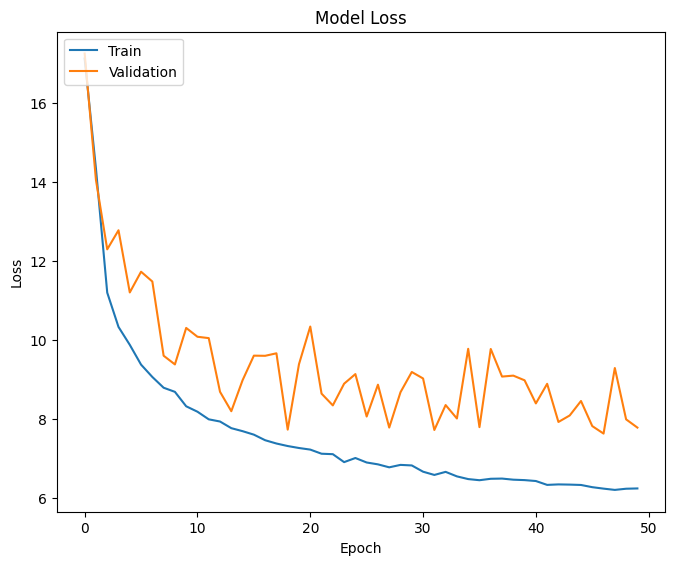

In [55]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0, hspace=0.25, wspace = 0.35)

### Plotting Gender Accuracy

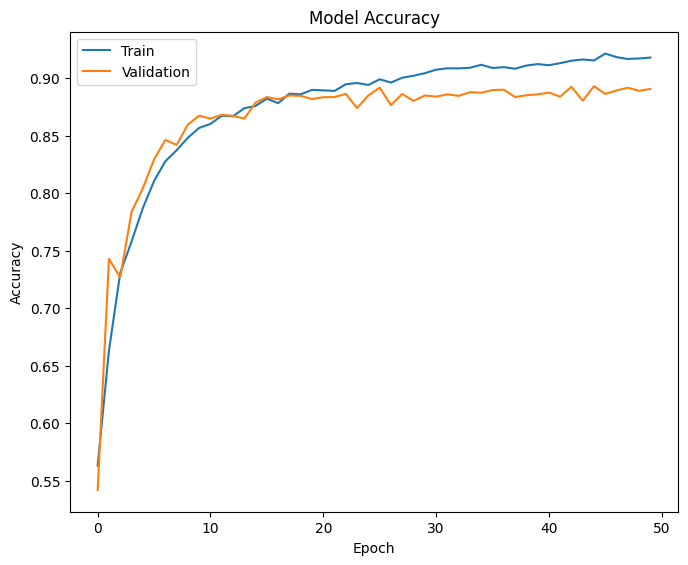

In [58]:
plt.plot(History.history['sex_out_acc'])
plt.plot(History.history['val_sex_out_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0, hspace=0.25, wspace = 0.35)

### Plotting Age Accuracy

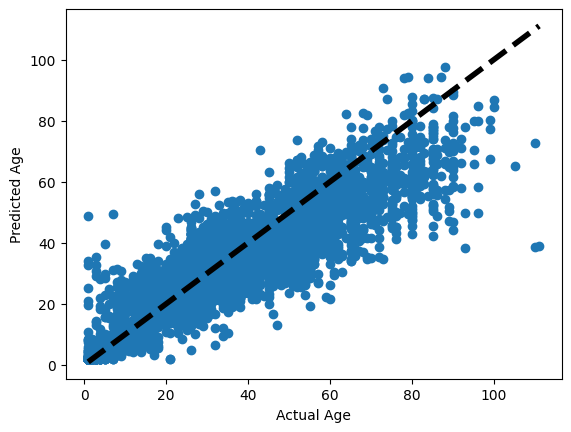

In [60]:
fig, ax = plt.subplots()
ax.scatter(y_test_2[1], pred[1])
ax.plot([y_test_2[1].min(), y_test_2[1].max()], [y_test_2[1].min(), y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

### Making Model Report
**Note: Gender only**

In [61]:
i=0
Pred_l = []

while(i<len(pred[0])):
    Pred_l.append(int(np.round(pred[0][i])))
    i += 1

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_test_2[0], Pred_l)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3096
           1       0.86      0.92      0.89      2831

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



### Confusion Matrix of the Model

In [63]:
results = confusion_matrix(y_test_2[0], Pred_l)

<AxesSubplot:>

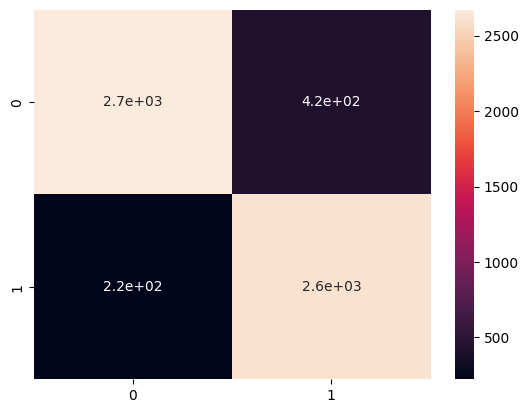

In [64]:
import seaborn as sns
sns.heatmap(results, annot=True)

### Testing the Model

In [65]:
def test_image(ind, images_f, images_f_2, Model_1):
    plt.imshow(images_f[ind])
    images_test = images_f_2[ind]
    pred_l = Model_1.predict(np.array([images_test]))
    sex_f = ['Male', 'Female']
    age = int(np.round(pred_l[1][0]))
    sex = int(np.round(pred_l[0][0]))
    print(f"Predicted Age is {age}")
    print(f"Predicted Gender is {sex_f[sex]}")

Predicted Age is 9
Predicted Gender is Male


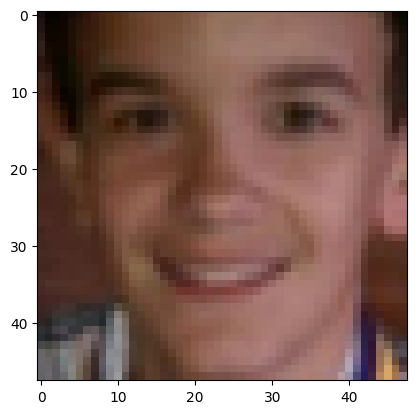

In [70]:
test_image(23, images_f, images_f_2, Model)

Predicted Age is 15
Predicted Gender is Female


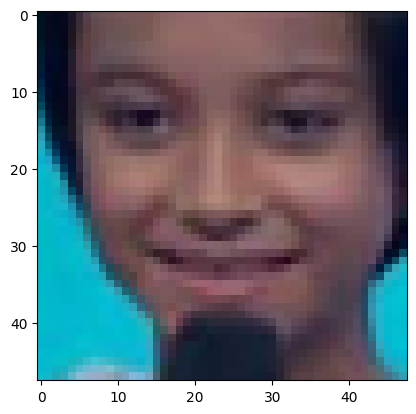

In [71]:

test_image(168, images_f, images_f_2, Model)

Predicted Age is 21
Predicted Gender is Male


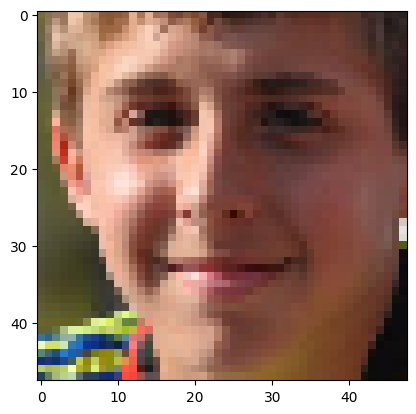

In [72]:
test_image(888, images_f, images_f_2, Model)

Predicted Age is 27
Predicted Gender is Female


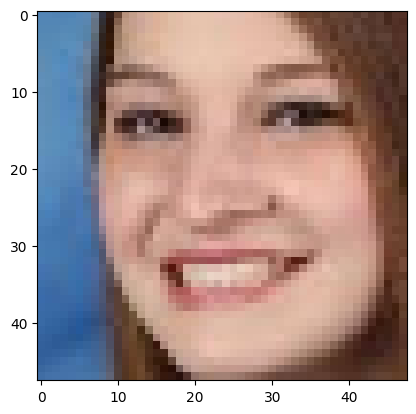

In [73]:

test_image(1288, images_f, images_f_2, Model)